In [38]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
from perceptron import Perceptron, PerceptronOptimizer, PerceptronOptimizer_minibatch, Perceptron_minibatch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Abstract

This blog post implements a simple perceptron algorithm and explores visualizations about the algorithm as a linear classifier. We also explored minibatch perceptron, and how using batched data for changing the weight vector can help speed, including an arbitrary number and when looking at the entire dataset in a single iteration.

We used data and the base of the training loop from generated by Professor Chodrow, while the implementation is done by me.

# Implementation

The code for the implementation can be found [here]()

# Creating data and checking for implementation

In order to check that my implementation of the perceptron algorithm works, I will use the data provided by Prof Chodrow. The data generates a feature matrix X and targets y, and also provides a plot to show it is linearly separable.


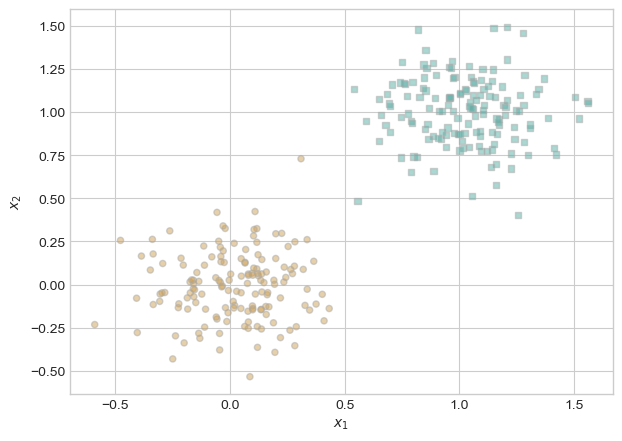

In [21]:
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

I then want to implement the minimal training loop from he lecture notes. This loop crates a new perceptron model then runs the loop until the loss is zero. If my implementation works, the loop should terminate when the loss is 0, meaning we have separated the data:

In [22]:

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

loss

tensor(0.)

Our tensor that holds the loss eventually converges at 0, proving our training loop and implementation work.

# Part B: Experiments

Now we can run experiments

## Experiment 1

We already have the code that plots out the perceptron data and generates points, now we need code to draw the line that can separate it.

In [23]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

For this experiment, we want to run the training loop but keep track of the losses in order to visualize how the algorithm changes teh location of the hyperplane to eventually separate the data. The dashed line is from the step before, and the data point that is circled shows which point is used to update. Ov

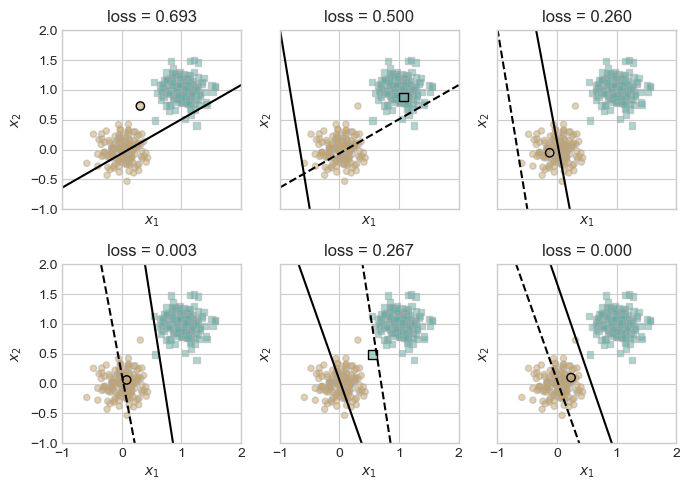

In [24]:
torch.manual_seed(1234567) # This code is from the lecture by Professor Chodrow

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # pick rand point
    i = torch.randint(n, size = (1,))
    xi = X[[i],:]
    yi = y[i]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    local_loss = opt.step(xi, yi)
    loss = p.loss(X, y).item()
    loss_vec.append(loss)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1

plt.tight_layout()

When we keep track of the loss, we can see that we can visualize how the loss eventually reaches zero and the hyperplane separates the data.

We can also plot the loss overtime using our loss_vec to see how it eventually reaches zero over a certain amount of iterations:

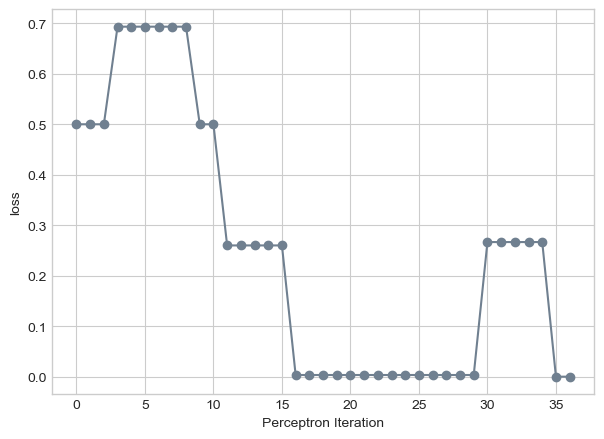

In [25]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "loss")

## Experiment 2

If instead we generate new data that is not linearly separable, we can visualize how the loss never reaches zero and the weight value never reaches an optimal state to separate the data:


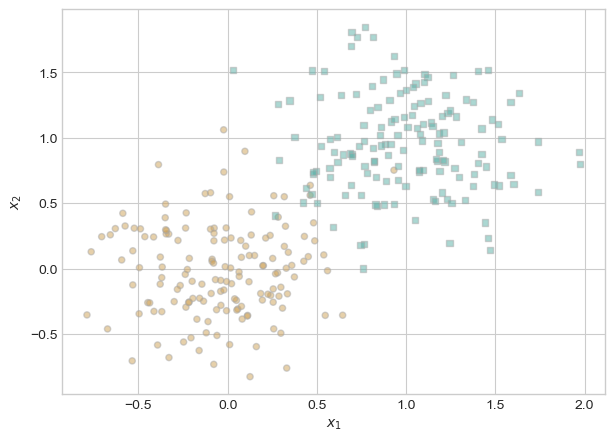

In [30]:
torch.manual_seed(1234)

X, y = perceptron_data(n_points = 300, noise = 0.35)

fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X, y, ax)

We can run a similar training loop, but because we know the loss will never converge at 0, we can set the limit iterations to 500.

In [31]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

iteration = 0

while  loss > 0 and iteration < 500:
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

    iteration += 1

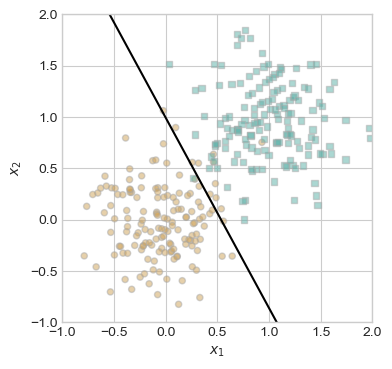

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, -1, 2, ax, color = "black")

The line seems to try to separate the data after 500 iterations, but the loss is not 0, although it can be close:

In [33]:
loss.item()

0.04333333298563957

We can visualize the loss:

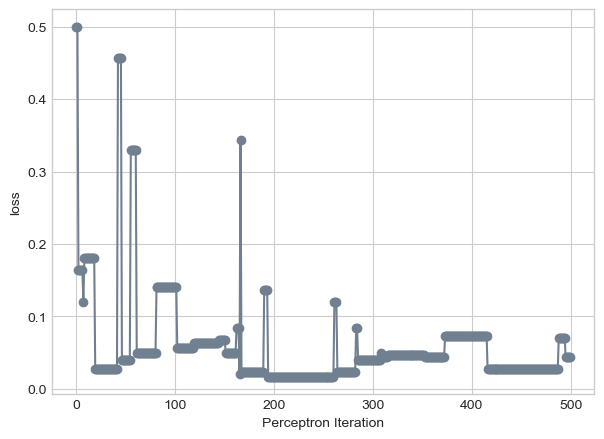

In [34]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "loss")

## Experiment 3

We can also experiment with the perceptron algorithm in more than 2 dimensions. We can run the following code on data with 5 features.

In [35]:
torch.manual_seed(1234)

def perceptron_data_dimensions(n_points = 300, noise = 0.35, dimensions = 5):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points, dimensions))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data_dimensions(n_points = 300, noise = 0.35, dimensions = 5)

In [36]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

iteration = 0

while iteration < 1000 and loss > 0:
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

    iteration += 1

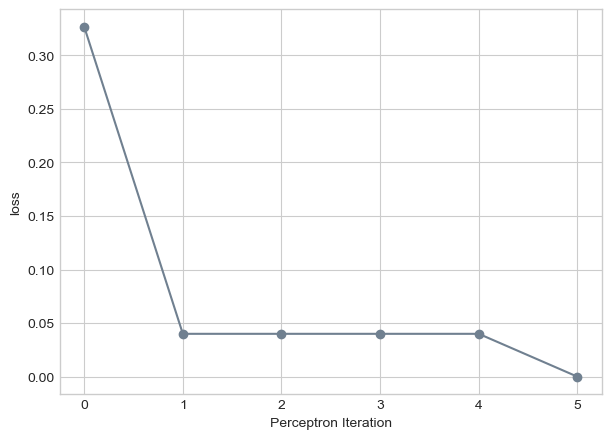

In [37]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "loss")

The code above shows the loss converges to 0 after only 5 iterations, showing this multi-dimensional data is linearly separable.

# Part C: Mini batch

In this section, we run the algorithm with updates in batches. We update the wight based on the updates of k points and then averaging them to the new weight. We need to implement learning_rate into a new, updated perceptron class - provided in the same perceptron.py. Learning rate determines how fast the weight changes.

We need to explore how minibatch perceptron does in a training loop compared to normal perceptron. This data is linearly separable.

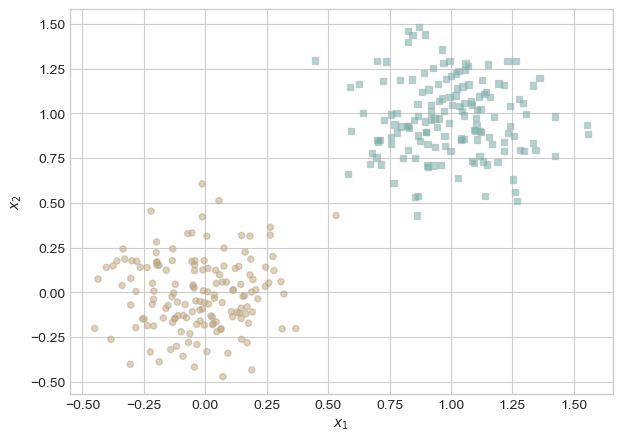

In [39]:
torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,2))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X, y, ax)

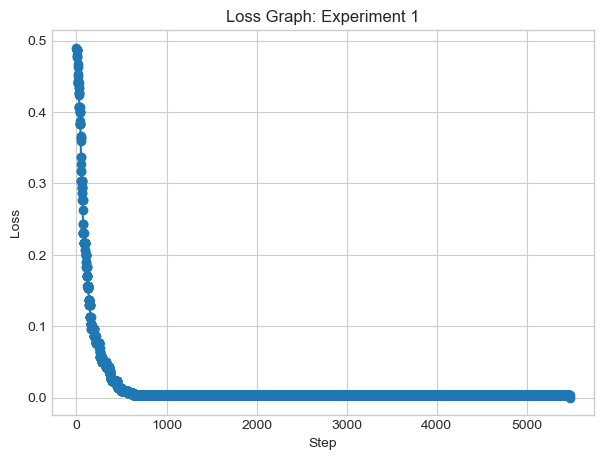

loss:  tensor(0.)


In [52]:
perceptron_data(n_points = 300, noise = 0.2)

# instantiate a model and an optimizer
p = Perceptron_minibatch() 
opt = PerceptronOptimizer_minibatch(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    # not part of the update: just for tracking our progress  
    loss = p.loss(X, y) 
    loss_vec.append(loss)  
    
    # get k points - code provided by Professor Phil Chodrow
    k = 1
    ix = torch.randperm(X.size(0))[:k]
    xi = X[ix,:]
    yi = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(xi, yi)

plt.plot(loss_vec, marker='o', linestyle='-')
plt.title('Loss Graph: Experiment 1')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()
print("loss: ", loss_vec[-1])

We eventually see that with minibatch perceptron algorithm, the loss still converges at 0 and the data is linearly separable.

We can test on non linearly separable data light overlapping data:

loss: 0.07000000029802322


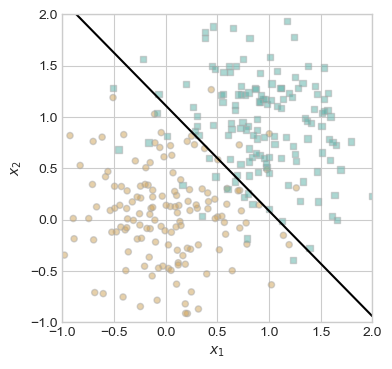

In [55]:
X, y = perceptron_data(noise=0.5)

# instantiate a model and an optimizer
p = Perceptron_minibatch() 
opt = PerceptronOptimizer_minibatch(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

iterations = 0
while iterations < 1000: 
    # not part of the update: just for tracking our progress  
    loss = p.loss(X, y).item()
    loss_vec.append(loss)
    
    # get k points - code provided by Professor Phil Chodrow
    k = 1
    ix = torch.randperm(X.size(0))[:k]
    xi = X[ix,:]
    yi = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(xi, yi)
        
    iterations += 1

#loss_graph(loss_vec=loss_vec)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
print("loss:", loss)


This data is overlapping, and even though it cannot converge, it is semi-accurate. We can also view the change in loss:


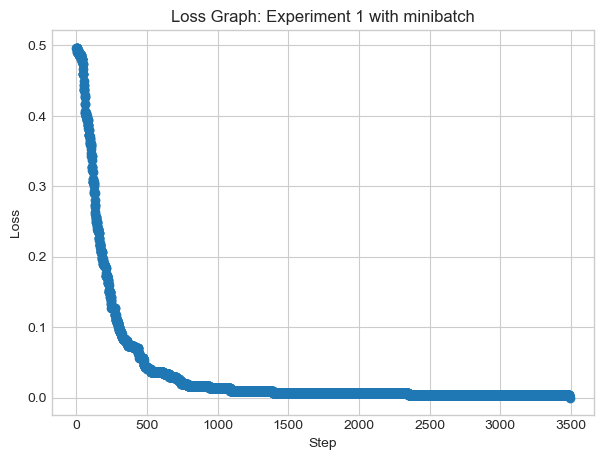

loss:  tensor(0.)


In [62]:
plt.plot(loss_vec, marker='o', linestyle='-')
plt.title('Loss Graph: Experiment 1 with minibatch')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()
print("loss: ", loss_vec[-1])

We see that after 1000 iterations, the loss struggles to find an optimal weight, but the hyperplane finds an "accurate" location

## Experiment 2

Now with a new K value of 10 and with 5 dimensions, we need to see if the data is linearly separable:


In [59]:
X, y = perceptron_data_dimensions(n_points = 300, noise = 0.2, dimensions=5)

# instantiate a model and an optimizer
p = Perceptron_minibatch() 
opt = PerceptronOptimizer_minibatch(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    # not part of the update: just for tracking our progress  
    loss = p.loss(X, y) 
    loss_vec.append(loss)  
    
    # get k points - code provided by Professor Phil Chodrow
    k = 10
    ix = torch.randperm(X.size(0))[:k]
    xi = X[ix,:]
    yi = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(xi, yi)

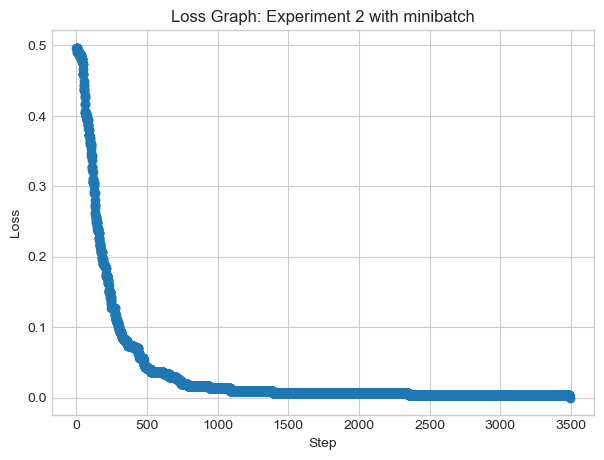

loss:  tensor(0.)


In [61]:
plt.plot(loss_vec, marker='o', linestyle='-')
plt.title('Loss Graph: Experiment 2 with minibatch')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()
print("loss: ", loss_vec[-1])

It seems that our final loss is 0 after qualified leader, showing the data is linearly separable with minibatch at high dimensions adn k = 10

## Experiment 3

Finally, we will see if the data is linearly separable if k = n — or the entire size of the feature list

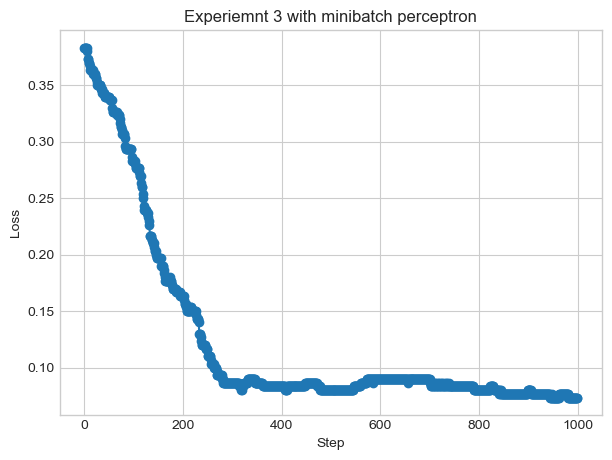

loss:  0.07333333045244217


In [64]:
X, y = perceptron_data(n_points = 300, noise = 0.5)
# instantiate a model and an optimizer
p = Perceptron_minibatch() 
opt = PerceptronOptimizer_minibatch(p)

# for keeping track of loss values
loss_vec = []

n = X.size()[0]
iterations = 0
while iterations < 1000: # dangerous -- only terminates if data is linearly separable
    # not part of the update: just for tracking our progress  
    loss = p.loss(X, y).item()
    loss_vec.append(loss)  
    
    # get k points - code provided by Professor Phil Chodrow
    k = n
    ix = torch.randperm(X.size(0))[:k]
    xi = X[ix,:]
    yi = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(xi, yi)
        
    iterations += 1


plt.plot(loss_vec, marker='o', linestyle='-')
plt.title('Experiemnt 3 with minibatch perceptron')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()
print("loss: ", loss_vec[-1])

The data is not linearly separable, as the loss function did not converge on zero.

# Runtime

The runtime for an iteration in the training loop usi O(p) where the p is the number of features. For minibatch, the single iteration is O(kp) where K is the number of rows you are looking at in the batched data. The grad function computes score for a single point that is chosen randomly. 

# Conclusion

Overall, the perceptron algorithm is simple and built off of a linear model. It is really important as a linear classifier. On linearly sparable data, we are able to find a hyperplane that separates the data. I was also able to see the consequences of overlapping, non linearly separable data and how it can make training loops have no stopping point.

The minibatch perceptron algorithm added onto the original and how batched convergence can get around the limitations of regular perceptron. With the introduction of the learning rate, we can see the balance between convergence and efficiency.